# Graph Tool Sanbox

In [12]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pickle
import json
from glob import glob
from tqdm import tqdm
import random

Grafo Minimo reproducible similar al grafo grande

This is our toy edge list [(0, 1), (1, 2), (2, 0), (3, 1), (4, 5), (5, 4)]
This are our toy weights [8, 9, 7, 10, 12, 11]


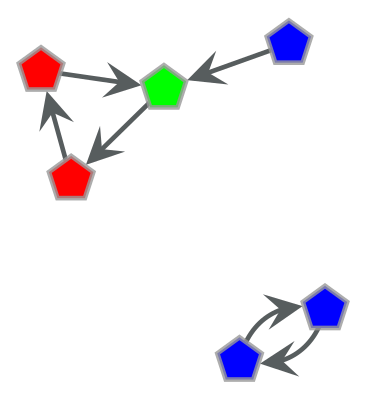

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa259557fd0, at 0x7fa2593bf650>

In [74]:
# TOY GRAPH FOR CALCULATIONS
random.seed(1)

edge_list = [(0,1),(1,2),(2,0),(3,1),(4,5),(5,4)]
vertex_dict = {
    'label': 'a b c d e f'.split(' '),
    'pa': 'd c d i i i'.split(' '),
    'id': [i for i in range(10000,10006)]
}
color = {
    'i': (0,0,1), # Azul
    'd': (1,0,0), # Rojo
    'c': (0,1,0) # Centro
}
weights = [8,9,7,10,12,11]
g = gt.Graph(directed=True)
print(f'This is our toy edge list {edge_list}')
print(f'This are our toy weights {weights}')

g.add_edge_list(edge_list=edge_list)

# Create an edge property map for weights
edge_weight_map = g.new_edge_property("double")
edge_date_map = g.new_edge_property('string')

# Create a Vertex property map for labels
vertex_PA_map = g.new_vertex_property('string')
vertex_ID_map = g.new_vertex_property('int64_t')
vertex_color_map = g.new_vertex_property('vector<double>')
vertex_label_map = g.new_vertex_property('string')

# Add edges properties
edge_list = g.get_edges()
for i, e in enumerate(edge_list):
    edge_weight_map[e] = weights[i]
    edge_date_map[e] = '2021-05-16'

# Add Vertex properties
vertex_list = g.get_vertices()
for v in vertex_list:
    vertex_PA_map[v] = vertex_dict['pa'][v]
    vertex_ID_map[v] = vertex_dict['id'][v]
    vertex_label_map[v] = vertex_dict['label'][v]
    vertex_color_map[v] = color[vertex_dict['pa'][v]]

# Assign the maps to the Graph Object
g.vp['Political Label'] = vertex_PA_map
g.vp['User ID'] = vertex_ID_map
g.vp['Label'] = vertex_label_map
g.vp['Color'] = vertex_color_map
g.ep['Normal Weights'] = edge_weight_map
g.ep['Ending date'] = edge_date_map

# Create a graph layout and drawing
pos = gt.sfdp_layout(g)

gt.graph_draw(g,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

Filtrar el grafo en función de alguna propidad categorica del nodo. en este caso el espéctro político

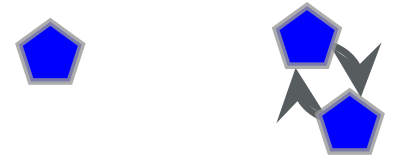

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f40364c07d0, at 0x7f3f75ce82d0>

In [6]:
# Filter edges connected to nodes labeled 'i'
filtered_edges = g.new_edge_property("bool")
filtered_edges.a = False

# Filter nodes with label 'i'
filtered_nodes = g.new_vertex_property("bool")
filtered_nodes.a = False

for v in g.vertices():
    if g.vertex_properties['Political Label'][v] == 'i':
        filtered_nodes[v] = True
        for edge in v.out_edges():
            if g.vertex_properties['Political Label'][edge.target()] == 'i':
                filtered_edges[edge] = True

# Generate the subgraph using the filtered nodes and edges
subgraph = gt.GraphView(g, vfilt=filtered_nodes, efilt=filtered_edges)

gt.graph_draw(subgraph,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

In [68]:
def get_adjacency(g : gt.Graph, weight = None) -> np.ndarray:
    # Get EdgePropertyMap for Weights in Adjacency
    if weight is not None:
        weights = g.ep[weight]
    else: weights = weight

    adj = gt.adjacency(g, weight = weights).T
    return adj.toarray()

def get_types_array(g: gt.Graph, types = None) -> np.ndarray:
    t = g.vp[types].get_2d_array([0])[0]
    return t

def get_types_dict(g: gt.Graph, types = None) -> dict:
    # Get array of types
    t = get_types_array(g,types)
    T = {}
    for tipo in np.unique(t):
        row=[]
        for i in t:
            if i == tipo:
                row.append(1)
            else:
                row.append(0)        
        T[str(tipo)] = row
    return T

def get_types_index(g: gt.Graph, types = None) -> dict:
    T = get_types_dict(g, types)
    Type_to_row = {k:v for v,k in enumerate(T.keys())}
    return Type_to_row

def get_types_matrix(g: gt.Graph, types = None) -> np.ndarray:
    types_dict = get_types_dict(g,types = types)
    types_vector = types_dict.values()
    return np.array(list(types_vector)).T

def get_contact_matrix(g, types = None, weights = None) -> np.ndarray:
    adj = get_adjacency(g, weights)
    
    types_matrix = get_types_matrix(g, types = types)
    
    M = types_matrix.T.dot(adj).dot(types_matrix)

    return M

In [57]:
def to_networkx(g: gt.Graph) -> nx.Graph:
    
    if g.is_directed():
        nx_graph = nx.DiGraph()
    else:
        nx_graph = nx.Graph()

    # Add nodes with their properties to the NetworkX graph
    for v in g.vertices():
        node_properties = {prop_name: g.vp[prop_name][v] for prop_name in g.vp}
        nx_graph.add_node(int(v), **node_properties)

    # Add edges with their properties to the NetworkX graph
    for e in g.edges():
        edge_properties = {prop_name: g.ep[prop_name][e] for prop_name in g.ep}
        nx_graph.add_edge(int(e.source()), int(e.target()), **edge_properties)
    
    return nx_graph

In [56]:
def diametros(g: gt.Graph, w = None):
    if w==None:
        weights = None
        name = 'Diametro Simple'
    else:
        weights =g.ep[w]
        name = f'Diametro de {w}'
    diametros= []
    for v in g.vertices():
        d = gt.pseudo_diameter(g, source = v, weights = weights)
        diametros.append(d)

    diametros = pd.DataFrame(diametros, columns = [name, 'Edge'])
    return diametros.drop(columns='Edge')

In [92]:
def descriptive(g: gt.Graph, w=None) -> pd.DataFrame:
    # Date
    date = g.ep['Ending date'][g.edges().next()]
    
    # Edges, Nodes and Dyads
    nodes = g.num_vertices()
    edges = g.num_edges()
    dyads = edges/2
    density = (2*edges) / (nodes * nodes -1)
    
    # Connected Components 
    SCC, hist = gt.label_components(g, directed=True)
    WCC, hist = gt.label_components(g, directed=False)
    
    N_SCC = len(set(SCC.a))
    N_WCC = len(set(WCC.a))
    
    # Diameter
    diametro = diametros(g,w)
    valor_diametro = float(diametro.max(axis=0).iloc[0])
    tipo_de_diametro = diametro.max(axis=0).index[0]
    
    results = {
        'Graph Date': date,
        'Nodes': nodes,
        'Edges': edges,
        'Dyads': dyads,
        'Density': density,
        'Strongly Connected Components': N_SCC,
        'Weakly Connected Components': N_WCC,
        tipo_de_diametro: valor_diametro
    }
    return pd.DataFrame([results]).set_index('Graph Date')

descriptive(g, 'Normal Weights')

,Nodes,Edges,Dyads,Density,Strongly Connected Components,Weakly Connected Components,Diametro de Normal Weights
Graph Date,,,,,,,
2021-05-16,6,6,3.0,0.342857,3,2,26.0
